In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import os
import glob
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt
import modules_TFM as mod

from scipy.optimize import curve_fit
import scipy.stats as stats

In [4]:
import h5py

df_s2 = []
df_s1 = []

for i in range(3):
    
    file_path = f"/Users/pablovazquez/Library/CloudStorage/OneDrive-UniversidadedeSantiagodeCompostela/Máster/TFM/pmaps/kr83m_000{i}.pmaps"
    
    with h5py.File(file_path, 'r') as f:
        pmaps_group = f['PMAPS']  # Acceder al grupo
        dataset_name_s2 = list(pmaps_group.keys())[2]  # Seleccionar el dataset que quieras
        dataset_name_s1 = list(pmaps_group.keys())[0]
        dataset_s2 = pmaps_group[dataset_name_s2][:]  # Convertir a NumPy array
        dataset_s1 = pmaps_group[dataset_name_s1][:]
        data_s2 = pd.DataFrame(dataset_s2)
        data_s1 = pd.DataFrame(dataset_s1)
        df_s2.append(data_s2)
        df_s1.append(data_s1)
dst_s2= pd.concat(df_s2, ignore_index=True)
dst_s1= pd.concat(df_s1, ignore_index=True)
# Mostrar las primeras filas
#print(f"Dataset: {dataset_name}")
dst_s1

#pd.read_hdf(file_path, 'PMAPS/S2Si')
#us 
#from invisible_cities.io.pmaps_io import load_pmaps
#pmaps = load_pmaps(file_path)
#pmaps

,event,peak,time,bwidth,ene
0,0,0,10000.0,25.0,4.263669
1,0,0,10025.0,25.0,4.070536
2,0,0,10050.0,25.0,2.671846
3,0,0,10075.0,25.0,5.098412
4,0,0,10100.0,25.0,2.258460
...,...,...,...,...,...
32136,2999,0,10225.0,25.0,0.000000
32137,2999,0,10250.0,25.0,0.000000
32138,2999,0,10275.0,25.0,0.763523
32139,2999,0,10300.0,25.0,0.000000


In [4]:
DTs=[]
energies=[]

for i in range(max(dst_s1.event.unique())):
    DTs.append(((dst_s2[dst_s2.event==i].time.to_numpy())-dst_s1[dst_s1.event==0].time.to_numpy()[0])*10**(-3))
    energies.append(np.array(dst_s2[dst_s2.event==i].ene.to_numpy()))

for i, drift in enumerate(DTs):
    if len(drift)<=2:
        del DTs[i]
        del energies[i]
        
def skewed_gaussian(x, A, mu, sigma, alpha):
    norm = stats.norm.pdf((x - mu) / sigma)
    cdf  = stats.norm.cdf(alpha * (x - mu) / sigma)
    return A * norm * cdf

def gaussian(x, A, mu, sigma):
    norm = stats.norm.pdf((x - mu) / sigma)
    return A * norm 


In [5]:
params=[]
params_sk=[]

uncertainty_mean=[]
uncertainty_sigma=[]


for drift, energy in zip(DTs, energies):
    popt, pcov = curve_fit(gaussian, drift, energy, p0=[np.max(energy), np.mean(drift), np.std(drift)])
    params.append(popt)

    popt_sk, pcov_sk = curve_fit(skewed_gaussian, drift, energy, p0=[np.max(energy), np.mean(drift), np.std(drift), .5])
    params_sk.append(popt_sk)
    
    uncertainty_mean.append(np.sqrt(pcov[1][1]))
    uncertainty_sigma.append(np.sqrt(pcov[2][2]))

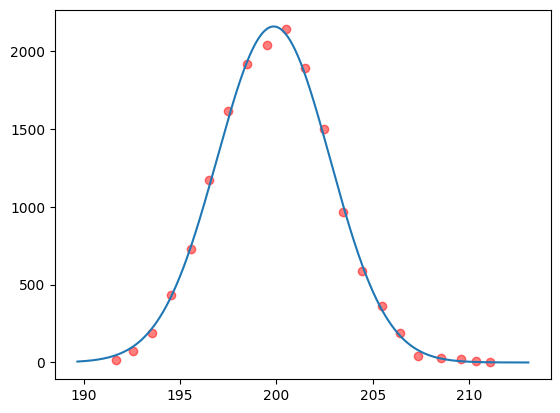

In [6]:
index=np.random.randint(0, len(DTs)- 20)

plt.scatter(DTs[index], energies[index], color = 'red', alpha = .5)
plt.plot(np.linspace(min(DTs[index])-2, max(DTs[index])+2, 1000), 
         skewed_gaussian(np.linspace(min(DTs[index])-2, 
                                     max(DTs[index])+2, 1000),
                                     *params_sk[index]));
plt.savefig('wave')

In [21]:
DT = np.zeros(len(DTs))
DT_rms = np.zeros(len(DTs)) 

for i, parameter in enumerate(params):
    DT[i] = parameter[1]
    DT_rms[i] = parameter[2]

#for i, parameter in enumerate(params_sk):
 #   DT[i] = parameter[1]
  #  DT_rms[i] = parameter[2]

def recta(x, a, b):
    return a*x+b
popt_linear, pcov_linear = curve_fit(recta, DT, DT_rms**2, p0=[0,0])

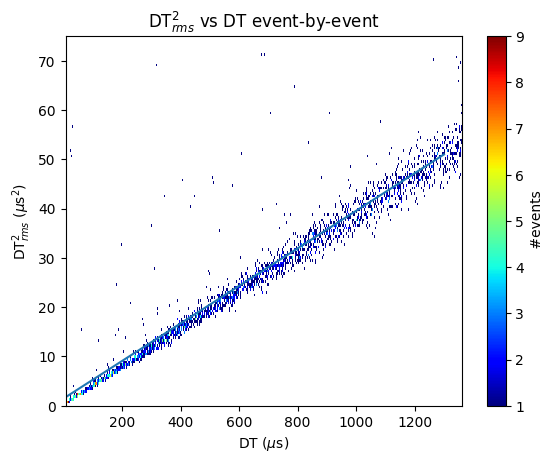

In [30]:
plt.hist2d(DT, DT_rms**2, bins = 500, cmin=1, cmap = 'jet');
plt.plot(np.linspace(0, 1300, 1000), recta(np.linspace(0, 1300, 1000), *popt_linear))

plt.xlabel(r'DT ($\mu$s)');
plt.ylabel(r'DT$_{rms}^2$ ($\mu$s$^2$)');
plt.colorbar(label = r' #events');
plt.title('DT$_{rms}^2$ vs DT event-by-event');
plt.ylim(0, 75)
plt.savefig('Fit event by event')

In [23]:
slope = popt_linear[0]
incert_slope=np.sqrt(pcov[0][0])

print('La presion reducida es:',4/58.42)
print(r'La temperatura reducida es, suponiendo T=25C:', (273.15+25)/289.733)

print('El factor de compresibilidad es entonces:', 0.971)

def diffusion_coef(T,Z,vd,P,DL):
    T0=293.15
    Z0=0.961
    dif=np.sqrt((2*T0*Z0*P*DL)/(T*Z*vd))
    return dif

def conversion_unidades(coefficient):
    '''
        Returns the diffusion coefficient in um/sqrt(mm)
    '''
    return coefficient * 10**3 * 10**(1/2)

P=4
T=25
Z=0.971
drift_velocity = 0.88


DL=slope*drift_velocity**2/2
diffusion_coefs=conversion_unidades(diffusion_coef(293.15, 0.971, drift_velocity, P, DL))


La presion reducida es: 0.06846970215679561
La temperatura reducida es, suponiendo T=25C: 1.029050884780125
El factor de compresibilidad es entonces: 0.971


In [24]:
diffusion_coefs

np.float64(1152.011387101962)

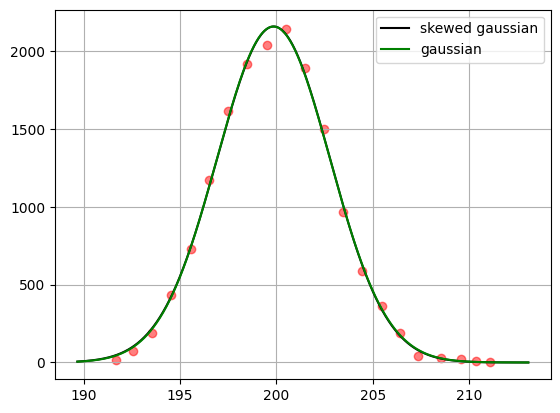

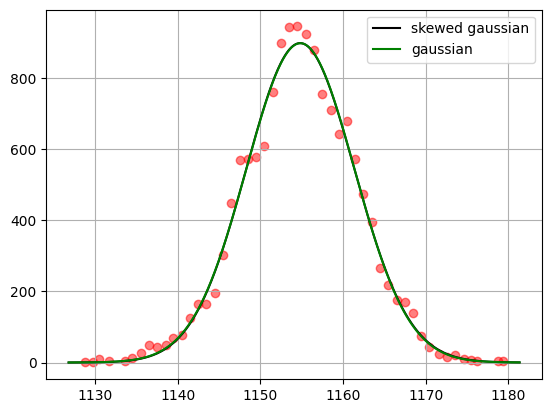

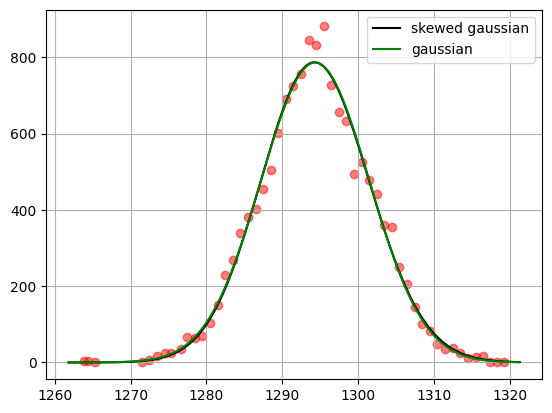

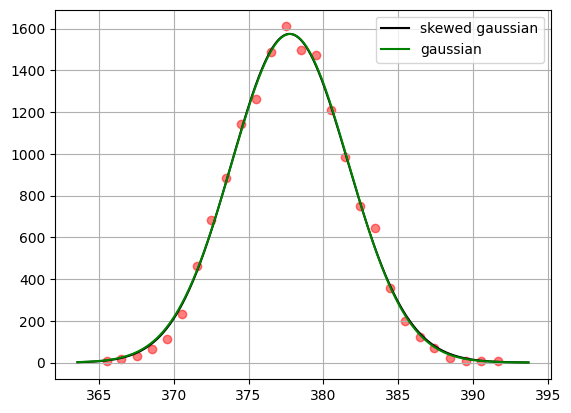

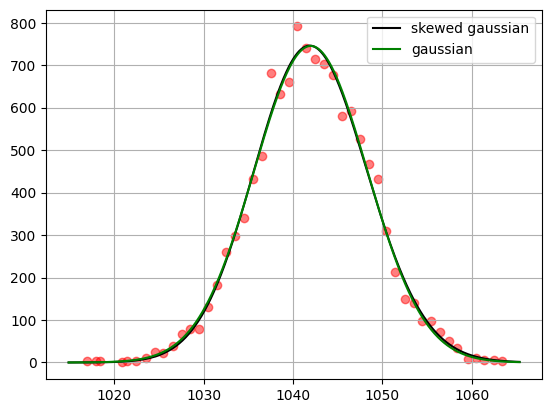

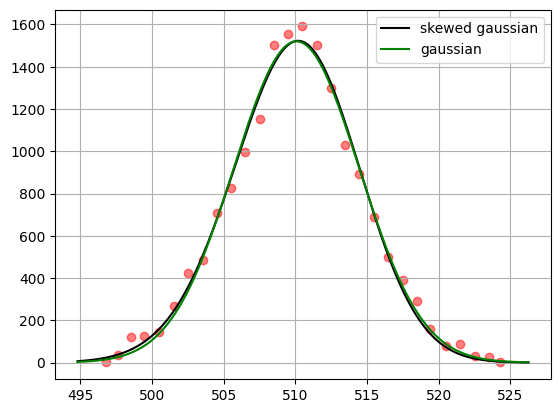

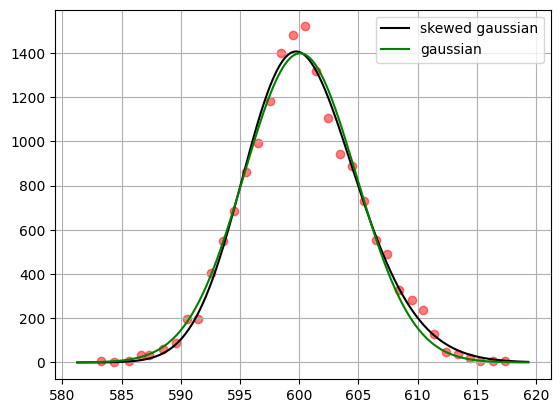

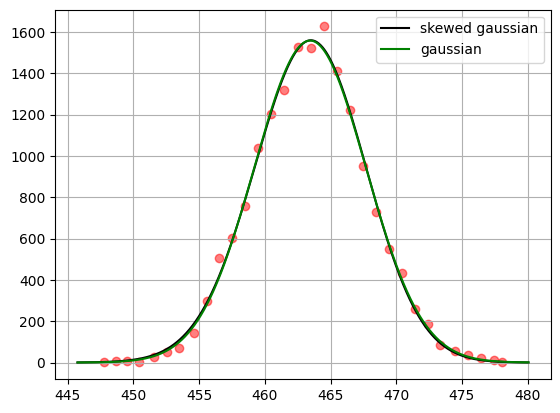

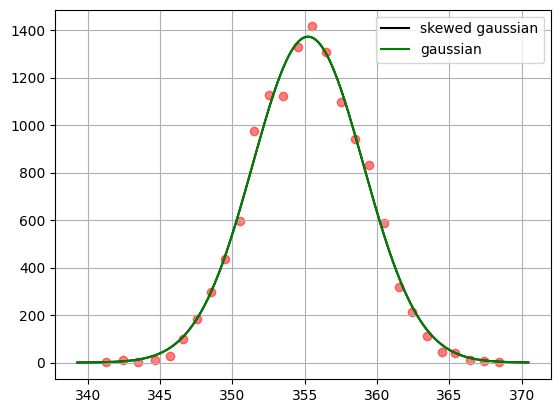

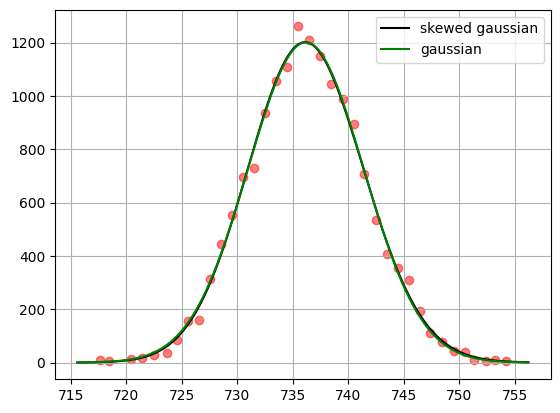

<Figure size 640x480 with 0 Axes>

In [25]:
for i in range(index, index + 10):
    plt.scatter(DTs[i], energies[i], color = 'red', alpha = .5);
    plt.plot(np.linspace(min(DTs[i])-2, max(DTs[i])+2, 1000), 
         skewed_gaussian(np.linspace(min(DTs[i])-2, 
                                     max(DTs[i])+2, 1000),
                                     *params_sk[i]), color = 'black', label = 'skewed gaussian');

    plt.plot(np.linspace(min(DTs[i])-2, max(DTs[i])+2, 1000), 
         gaussian(np.linspace(min(DTs[i])-2, 
                                     max(DTs[i])+2, 1000),
                                     *params[i]), color = 'green', label = 'gaussian');

    plt.legend();
    plt.grid(True);
    plt.figure();